# Intel Image Classification

In [115]:
!pip install tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.11.0


In [117]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = (224,224)


# Get device name (GPU)

In [118]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Let's see the available folders

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset_new'):
    print(dirname)

/content/drive/MyDrive/Dataset_new
/content/drive/MyDrive/Dataset_new/Train
/content/drive/MyDrive/Dataset_new/Train/glaucoma
/content/drive/MyDrive/Dataset_new/Train/cataract
/content/drive/MyDrive/Dataset_new/Train/normal
/content/drive/MyDrive/Dataset_new/Test
/content/drive/MyDrive/Dataset_new/Test/glaucoma
/content/drive/MyDrive/Dataset_new/Test/normal
/content/drive/MyDrive/Dataset_new/Test/cataract
/content/drive/MyDrive/Dataset_new/Pred


# Define classes

In [121]:
CLASSES = {'normal': 0, 'cataract': 1, 'glaucoma': 2}

# Get Train Sample

In [122]:
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=42)
    df.reset_index(drop=True, inplace=True)
    df = df[ : df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

In [123]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset_new/Train/*/*')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})
image_path_df_train = shuffle_prune(image_path_df_train, BATCH_SIZE)
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)

print('Train sample: ', len(image_path_df_train['class']), dict(image_path_df_train['class'].value_counts()))

Train sample:  3072 {0: 1056, 1: 1023, 2: 993}


# Get Test Sample

In [124]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset_new/Test/*/*')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))

Test sample:  3119 {'normal': 1074, 'cataract': 1038, 'glaucoma': 1007}


# Get Validation sample from test sample

In [125]:
image_path_df_test, image_path_df_val  = train_test_split(image_path_df_test, test_size=0.5, random_state=42, stratify=image_path_df_test['class'])
image_path_df_test = shuffle_prune(image_path_df_test, BATCH_SIZE)
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_val = shuffle_prune(image_path_df_val, BATCH_SIZE)
image_path_df_val['class'] = image_path_df_val['class'].map(CLASSES)

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))
print('Val  sample: ', len(image_path_df_val['class']), dict(image_path_df_val['class'].value_counts()))

Test sample:  1536 {0: 525, 1: 514, 2: 497}
Val  sample:  1536 {0: 529, 1: 512, 2: 495}


# Get files for prediction

In [126]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset_new/Pred/*')

image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')

Number filenames: 3119


# Get arrays and labels

In [127]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels

In [128]:
train_images, train_labels = get_images_and_labels_arrays(image_path_df_train)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')

Shape of train set: (3072, 224, 224, 3)
Shape of train set: (3072,)


In [129]:
val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')

Shape of validation set: (1536, 224, 224, 3)
Shape of validation set: (1536,)


In [130]:
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')

Shape of test set: (1536, 224, 224, 3)
Shape of test set: (1536,)


# We have 4 classes in this work like this

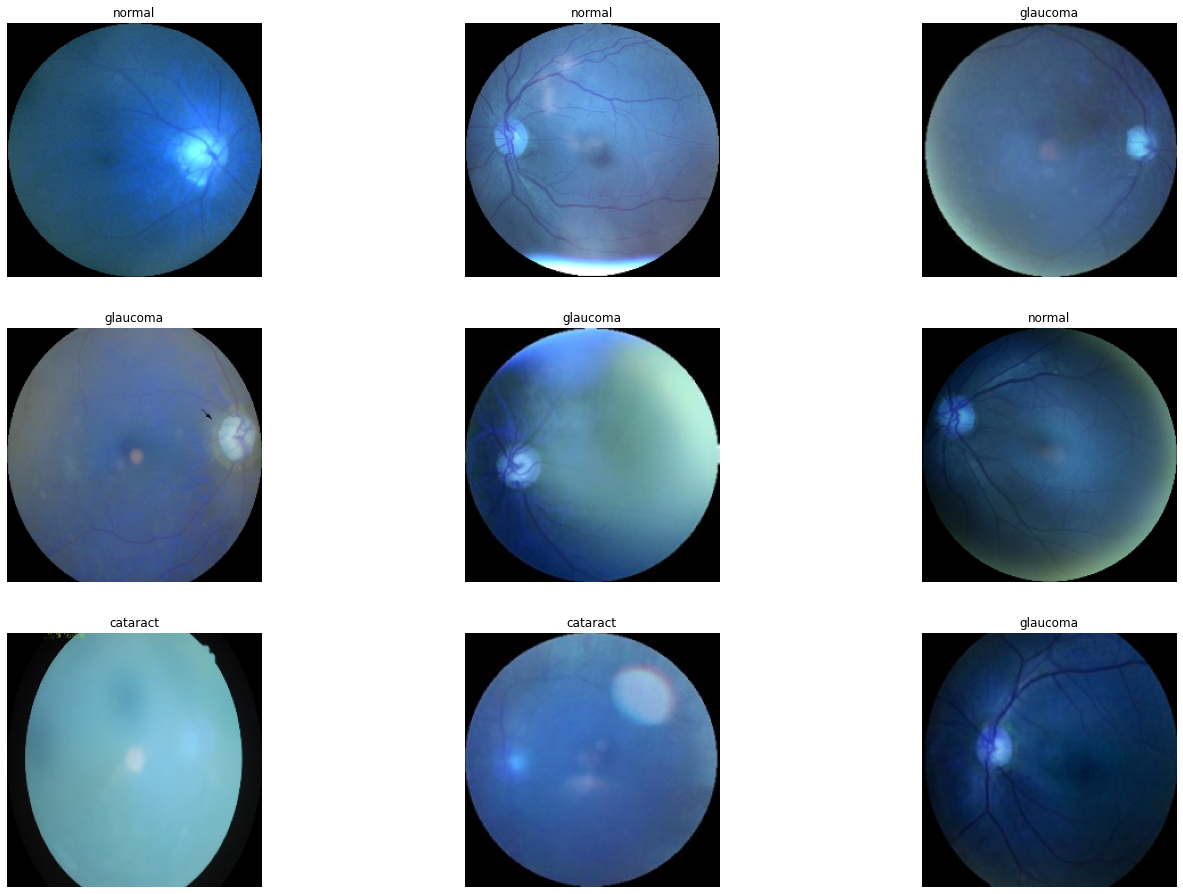

In [131]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == train_labels[rnd_number]][0])
        ax[i,j].axis('off')

# Define CNN Keras model and compile

In [132]:
def create_model():
    
    with tf.device('/gpu:0'):
    
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        x = layers.BatchNormalization()(input_layer)

        x = layers.Conv2D(filters=64, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
        x = layers.Dropout(0.1, name='dropout_1')(x)

        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
        x = layers.Dropout(0.1, name='dropout_2')(x)

        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
        x = layers.Dropout(0.1, name='dropout_3')(x)

        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
        x = layers.Dropout(0.1, name='dropout_4')(x)

        x = layers.Conv2D(filters=1024, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
        x = layers.Dropout(0.1, name='dropout_5')(x)
        

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)
       
        x = layers.Dense(128,activation='relu')(x)
        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                           

# Run model training

In [133]:
init_time = datetime.datetime.now()
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)
early_stop = EarlyStopping(monitor = 'val_accuracy', mode='min', verbose = 1, patience = 5)
trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[early_stop],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/20
24/24 [==============================] - 27s 1s/step - loss: 1.1625 - accuracy: 0.4144 - val_loss: 6.4227 - val_accuracy: 0.3333
Epoch 2/20
24/24 [==============================] - 24s 1s/step - loss: 0.9994 - accuracy: 0.5065 - val_loss: 1.7388 - val_accuracy: 0.3776
Epoch 3/20
24/24 [==============================] - 23s 976ms/step - loss: 0.9441 - accuracy: 0.5511 - val_loss: 1.3394 - val_accuracy: 0.4909
Epoch 4/20
24/24 [==============================] - 24s 1s/step - loss: 0.9191 - accuracy: 0.5742 - val_loss: 2.0781 - val_accuracy: 0.4512
Epoch 5/20
24/24 [==============================] - 24s 1s/step - loss: 0.8395 - accuracy: 0.6195 - val_loss: 1.2294 - val_accuracy: 0.4512
Epoch 6/20
24/24 [==============================] - 24s 1s/step - loss: 0.7406 - accuracy: 0.6816 - val_loss: 1.3994 - val_accuracy: 0.3900
Epoch 6: early stopping

Required time:  0:02:28.152300



# Training process

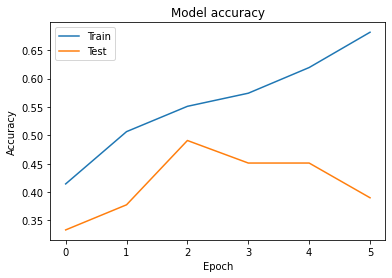

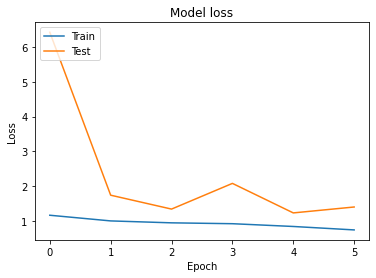

In [134]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the trained model

In [135]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('accuracy:', test_acc, '  loss: ',test_loss)

accuracy: 0.3828125   loss:  1.4372469186782837


# Prediction

In [136]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

48/48 [==============================] - 2s 34ms/step


array([2, 2, 2, ..., 2, 2, 2])

# Classification report & confusion matrix

              precision    recall  f1-score   support

           0       0.52      0.14      0.23       525
           1       0.98      0.08      0.15       514
           2       0.35      0.95      0.51       497

    accuracy                           0.38      1536
   macro avg       0.62      0.39      0.30      1536
weighted avg       0.62      0.38      0.29      1536
 



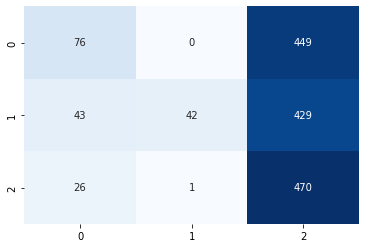

In [137]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's try pretrained model for example VGG19

In [138]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        
        
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        
        x = pretrained_model(input_layer)

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)       
        x = layers.Dense(128,activation='relu')(x)

        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

model = create_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 output (Dense)              (None, 3)                 387 

In [139]:
init_time = datetime.datetime.now()
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)
early_stop = EarlyStopping(monitor = 'val_accuracy', mode='min', verbose = 1, patience = 5)
trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[early_stop],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/20
24/24 [==============================] - 27s 1s/step - loss: 0.6674 - accuracy: 0.7214 - val_loss: 0.9132 - val_accuracy: 0.7188
Epoch 2/20
24/24 [==============================] - 25s 1s/step - loss: 0.3597 - accuracy: 0.8630 - val_loss: 0.7396 - val_accuracy: 0.7428
Epoch 3/20
24/24 [==============================] - 25s 1s/step - loss: 0.2780 - accuracy: 0.8929 - val_loss: 0.5219 - val_accuracy: 0.8008
Epoch 4/20
24/24 [==============================] - 24s 1s/step - loss: 0.2290 - accuracy: 0.9196 - val_loss: 0.4535 - val_accuracy: 0.8288
Epoch 5/20
24/24 [==============================] - 25s 1s/step - loss: 0.1907 - accuracy: 0.9391 - val_loss: 0.2932 - val_accuracy: 0.8835
Epoch 6/20
24/24 [==============================] - 25s 1s/step - loss: 0.1665 - accuracy: 0.9473 - val_loss: 0.2501 - val_accuracy: 0.8978
Epoch 6: early stopping

Required time:  0:02:30.354528



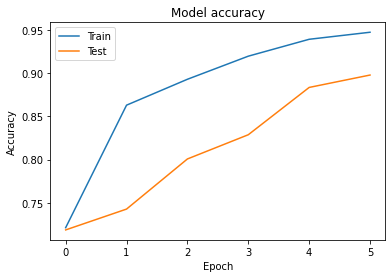

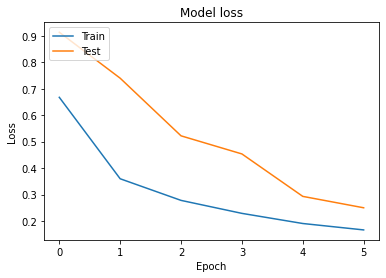

In [140]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [141]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.9055989384651184   loss:  0.24986125528812408


# Prediction

In [142]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

48/48 [==============================] - 7s 145ms/step


array([0, 2, 0, ..., 0, 2, 2])

# Classification report & confusion matrix

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       525
           1       0.98      0.86      0.91       514
           2       0.83      0.94      0.88       497

    accuracy                           0.91      1536
   macro avg       0.91      0.91      0.91      1536
weighted avg       0.91      0.91      0.91      1536
 



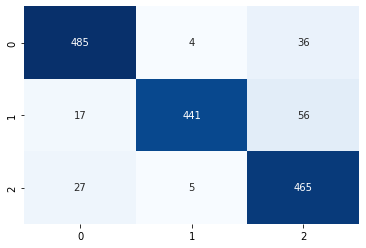

In [143]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's predict unlabeled images

In [144]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)
print(f'Shape of images set to prediction: {to_predict_images.shape}')

Shape of images set to prediction: (3119, 224, 224, 3)


In [145]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

98/98 [==============================] - 14s 147ms/step


array([2, 2, 2, ..., 2, 2, 2])

# Let's check random images

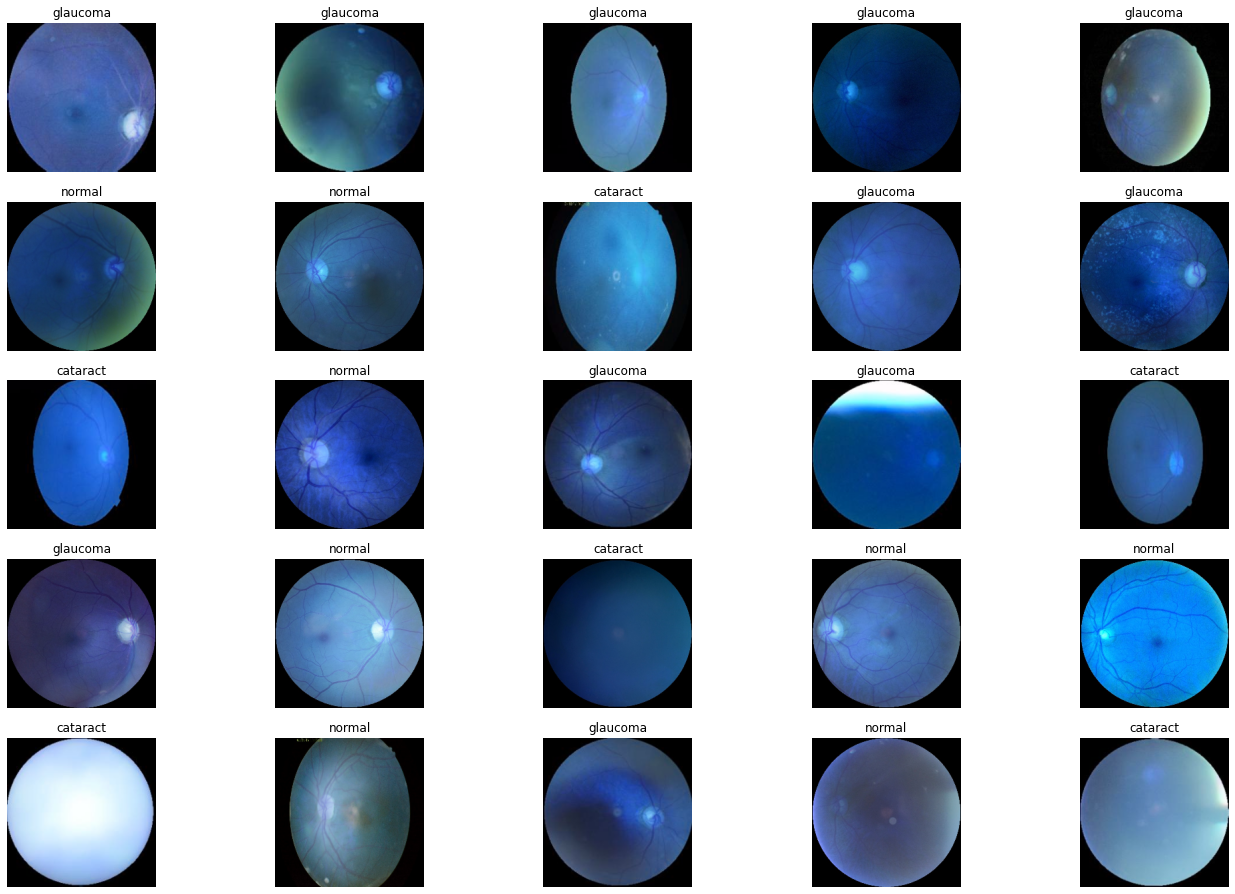

In [146]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(predict))
        ax[i,j].imshow(to_predict_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == predict[rnd_number]][0])
        ax[i,j].axis('off')

### **Testing**

In [147]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/singleInput/*')

image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')
print(filenames)

Number filenames: 2
['/content/drive/MyDrive/singleInput/normal.jpg', '/content/drive/MyDrive/singleInput/glaucoma.jpg']


In [148]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)

In [149]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

1/1 [==============================] - 0s 36ms/step


array([0, 2])

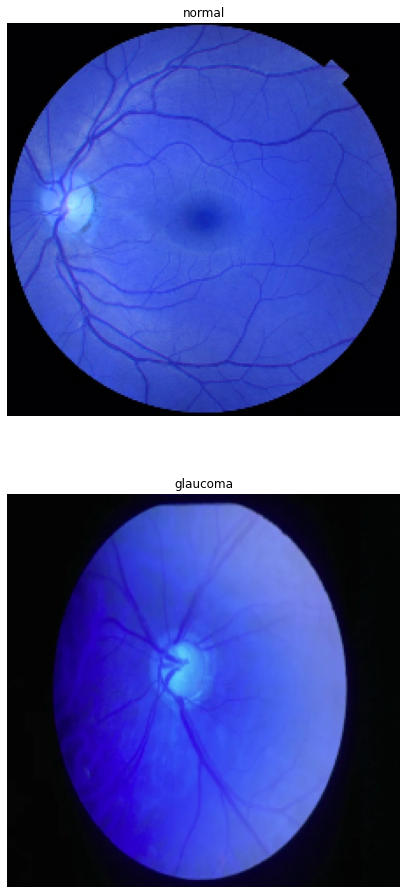

In [150]:
f,ax = plt.subplots(len(predict)) 
f.subplots_adjust(0,0,3,3)
i = 0
for j in range(0,len(predict),1):
    ax[j].imshow(to_predict_images[j])
    ax[j].set_title([key for key, val in CLASSES.items() if val == predict[j]][0])
    ax[j].axis('off')